In [ ]:
import pandas as pd
import numpy as np
import random 

## Setup MDP and QLearning 

In [ ]:
# MDP Code from Assignment 1 

import numpy as np

class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self,T,R,discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (self.nActions,self.nStates,self.nStates), "Invalid transition function: it has dimensionality " + repr(T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(2)-1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions" 
        assert R.shape == (self.nActions,self.nStates), "Invalid reward function: it has dimensionality " + repr(R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount
        
    

In [ ]:
# Q Learning 
class RL:
    def __init__(self, mdp, sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]
    

    def qLearning(self, s0, initialQ, nEpisodes, nSteps, lr = 0.3):
        '''qLearning algorithm.  Epsilon exploration and Boltzmann exploration
        are combined in one procedure by sampling a random action with 
        probabilty epsilon and performing Boltzmann exploration otherwise.  
        When epsilon and temperature are set to 0, there is no exploration.

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs: 
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''

        Q = np.zeros([self.mdp.nActions,self.mdp.nStates])
        policy = np.zeros(self.mdp.nStates,int)
        cs = 0 
        cumulative_r_per_episode = np.zeros(nEpisodes)
        count = 0 

        for n in range(nEpisodes):
          cs = 0 
          count = count + 1

          # New Epsilon 
          epsilon = 1/count
          # print('Epsilon value for episode {} is : {}'.format(count, epsilon))

          # Initial State choice  
          s = np.random.randint(0, self.mdp.nStates)
          
          for m in range (nSteps):

             
             # Action choice 
             p = np.random.random()
    
             if p < epsilon:
                # Random action with probability epsilon 
                a = np.random.randint(0, self.mdp.nActions)
             else : 
                # Greedy Action 
                a = Q[:, s].argmax()
             
             
             r, s_new = self.sampleRewardAndNextState(s, a)

             # Updating value of Q 
             delta = r + self.mdp.discount * Q[:, s_new].max() - Q[a, s]

             Q[a, s] = Q[a, s] + lr * delta

             # current state is updated
             s = s_new

             # Cumulative discounted reward over 100 steps 
             cs = cs + delta
            
          # Store reward per episode 
          cumulative_r_per_episode[n] = cs

        # Compute the policy 
        policy = Q.argmax(axis=0)

        return [Q,policy, cumulative_r_per_episode]    

## Formulating the problem as an MDP 

In [ ]:
# Read the data to compute the probabilities 

#data = pd.read_csv('/content/DataForMDPDataset.csv')
df1 = pd.read_csv('Final_Datasetnew.csv')
df2 = pd.read_csv('Final_Datasetnew2.csv')
data = pd.concat([df1, df2])

data.head()

,State,Action,Reward,Next_State
0,1,neutral,-1,1.0
1,1,neutral,10,2.0
2,2,neutral,10,2.0
3,2,neutral,-1,1.0
4,1,neutral,10,2.0


In [ ]:
# Need to label encode the actions 
# Positive - 2
# Neutral - 1
# Negative - 0 

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['Action'] = label_encoder.fit_transform(data['Action'])
print(data['Action'].unique())
data.head(5)

[1 2 0]


,State,Action,Reward,Next_State
0,1,1,-1,1.0
1,1,1,10,2.0
2,2,1,10,2.0
3,2,1,-1,1.0
4,1,1,10,2.0


### Probabilities for Action 0

In [ ]:
action0 = (data['Action'] == 0).sum()
action1 = (data['Action'] == 1).sum()
action2 = (data['Action'] == 2).sum()

act0st1 = data[(data['Action'] == 0) & (data['State'] == 1)]

act0pr1_1 = data[(data['Action'] == 0) & (data['State'] == 1) & 
              (data['Next_State'] == 1)]              
act0pr1_2 = data[(data['Action'] == 0) & (data['State'] == 1) & 
              (data['Next_State'] == 2)]
act0pr1_3 = data[(data['Action'] == 0) & (data['State'] == 1) & 
              (data['Next_State'] == 3)]
act0pr1_4 = data[(data['Action'] == 0) & (data['State'] == 1) & 
              (data['Next_State'] == 4)] 

pr0_1_1 = len(act0pr1_1)/len(act0st1)
pr0_1_2 = len(act0pr1_2)/len(act0st1)
pr0_1_3 = len(act0pr1_3)/len(act0st1)
pr0_1_4 = len(act0pr1_4)/len(act0st1)

act0st2 = data[(data['Action'] == 0) & (data['State'] == 2)]

act0pr2_1 = data[(data['Action'] == 0) & (data['State'] == 2) & 
              (data['Next_State'] == 1)]
act0pr2_2 = data[(data['Action'] == 0) & (data['State'] == 2) & 
              (data['Next_State'] == 2)]
act0pr2_3 = data[(data['Action'] == 0) & (data['State'] == 2) & 
              (data['Next_State'] == 3)]
act0pr2_4 = data[(data['Action'] == 0) & (data['State'] == 2) & 
              (data['Next_State'] == 4)] 

pr0_2_1 = len(act0pr2_1)/len(act0st2)
pr0_2_2 = len(act0pr2_2)/len(act0st2)
pr0_2_3 = len(act0pr2_3)/len(act0st2)
pr0_2_4 = len(act0pr2_4)/len(act0st2)

act0st3 = data[(data['Action'] == 0) & (data['State'] == 3)]

act0pr3_1 = data[(data['Action'] == 0) & (data['State'] == 3) & 
              (data['Next_State'] == 1)]
act0pr3_2 = data[(data['Action'] == 0) & (data['State'] == 3) & 
              (data['Next_State'] == 2)]
act0pr3_3 = data[(data['Action'] == 0) & (data['State'] == 3) & 
              (data['Next_State'] == 3)]
act0pr3_4 = data[(data['Action'] == 0) & (data['State'] == 3) & 
              (data['Next_State'] == 4)]

pr0_3_1 = len(act0pr3_1)/len(act0st3)
pr0_3_2 = len(act0pr3_2)/len(act0st3)
pr0_3_3 = len(act0pr3_3)/len(act0st3)
pr0_3_4 = len(act0pr3_4)/len(act0st3)

act0st4 = data[(data['Action'] == 0) & (data['State'] == 4)]

act0pr4_1 = data[(data['Action'] == 0) & (data['State'] == 4) & 
              (data['Next_State'] == 1)]
act0pr4_2 = data[(data['Action'] == 0) & (data['State'] == 4) & 
              (data['Next_State'] == 2)]
act0pr4_3 = data[(data['Action'] == 0) & (data['State'] == 4) & 
              (data['Next_State'] == 3)]
act0pr4_4 = data[(data['Action'] == 0) & (data['State'] == 4) & 
              (data['Next_State'] == 4)]

pr0_4_1 = len(act0pr4_1)/len(act0st4)
pr0_4_2 = len(act0pr4_2)/len(act0st4)
pr0_4_3 = len(act0pr4_3)/len(act0st4)
pr0_4_4 = len(act0pr4_4)/len(act0st4)


### For Action 1

In [ ]:
act1st1 = data[(data['Action'] == 1) & (data['State'] == 1)]

act1pr1_1 = data[(data['Action'] == 1) & (data['State'] == 1) & 
              (data['Next_State'] == 1)]              
act1pr1_2 = data[(data['Action'] == 1) & (data['State'] == 1) & 
              (data['Next_State'] == 2)]
act1pr1_3 = data[(data['Action'] == 1) & (data['State'] == 1) & 
              (data['Next_State'] == 3)]
act1pr1_4 = data[(data['Action'] == 1) & (data['State'] == 1) & 
              (data['Next_State'] == 4)] 

pr1_1_1 = len(act1pr1_1)/len(act1st1)
pr1_1_2 = len(act1pr1_2)/len(act1st1)
pr1_1_3 = len(act1pr1_3)/len(act1st1)
pr1_1_4 = len(act1pr1_4)/len(act1st1)

act1st2 = data[(data['Action'] == 1) & (data['State'] == 2)]

act1pr2_1 = data[(data['Action'] == 1) & (data['State'] == 2) & 
              (data['Next_State'] == 1)]
act1pr2_2 = data[(data['Action'] == 1) & (data['State'] == 2) & 
              (data['Next_State'] == 2)]
act1pr2_3 = data[(data['Action'] == 1) & (data['State'] == 2) & 
              (data['Next_State'] == 3)]
act1pr2_4 = data[(data['Action'] == 1) & (data['State'] == 2) & 
              (data['Next_State'] == 4)] 

pr1_2_1 = len(act1pr2_1)/len(act1st2)
pr1_2_2 = len(act1pr2_2)/len(act1st2)
pr1_2_3 = len(act1pr2_3)/len(act1st2)
pr1_2_4 = len(act1pr2_4)/len(act1st2)

act1st3 = data[(data['Action'] == 1) & (data['State'] == 3)]

act1pr3_1 = data[(data['Action'] == 1) & (data['State'] == 3) & 
              (data['Next_State'] == 1)]
act1pr3_2 = data[(data['Action'] == 1) & (data['State'] == 3) & 
              (data['Next_State'] == 2)]
act1pr3_3 = data[(data['Action'] == 1) & (data['State'] == 3) & 
              (data['Next_State'] == 3)]
act1pr3_4 = data[(data['Action'] == 1) & (data['State'] == 3) & 
              (data['Next_State'] == 4)]

pr1_3_1 = len(act1pr3_1)/len(act1st3)
pr1_3_2 = len(act1pr3_2)/len(act1st3)
pr1_3_3 = len(act1pr3_3)/len(act1st3)
pr1_3_4 = len(act1pr3_4)/len(act1st3)

act1st4 = data[(data['Action'] == 1) & (data['State'] == 4)]

act1pr4_1 = data[(data['Action'] == 1) & (data['State'] == 4) & 
              (data['Next_State'] == 1)]
act1pr4_2 = data[(data['Action'] == 1) & (data['State'] == 4) & 
              (data['Next_State'] == 2)]
act1pr4_3 = data[(data['Action'] == 1) & (data['State'] == 4) & 
              (data['Next_State'] == 3)]
act1pr4_4 = data[(data['Action'] == 1) & (data['State'] == 4) & 
              (data['Next_State'] == 4)]

pr1_4_1 = len(act1pr4_1)/len(act1st4)
pr1_4_2 = len(act1pr4_2)/len(act1st4)
pr1_4_3 = len(act1pr4_3)/len(act1st4)
pr1_4_4 = len(act1pr4_4)/len(act1st4)

### For Action 2 

In [ ]:
act2st1 = data[(data['Action'] == 2) & (data['State'] == 1)]

act2pr1_1 = data[(data['Action'] == 2) & (data['State'] == 1) & 
              (data['Next_State'] == 1)]              
act2pr1_2 = data[(data['Action'] == 2) & (data['State'] == 1) & 
              (data['Next_State'] == 2)]
act2pr1_3 = data[(data['Action'] == 2) & (data['State'] == 1) & 
              (data['Next_State'] == 3)]
act2pr1_4 = data[(data['Action'] == 2) & (data['State'] == 1) & 
              (data['Next_State'] == 4)] 

pr2_1_1 = len(act2pr1_1)/len(act2st1)
pr2_1_2 = len(act2pr1_2)/len(act2st1)
pr2_1_3 = len(act2pr1_3)/len(act2st1)
pr2_1_4 = len(act2pr1_4)/len(act2st1)

act2st2 = data[(data['Action'] == 2) & (data['State'] == 2)]

act2pr2_1 = data[(data['Action'] == 2) & (data['State'] == 2) & 
              (data['Next_State'] == 1)]
act2pr2_2 = data[(data['Action'] == 2) & (data['State'] == 2) & 
              (data['Next_State'] == 2)]
act2pr2_3 = data[(data['Action'] == 2) & (data['State'] == 2) & 
              (data['Next_State'] == 3)]
act2pr2_4 = data[(data['Action'] == 2) & (data['State'] == 2) & 
              (data['Next_State'] == 4)] 

pr2_2_1 = len(act2pr2_1)/len(act2st2)
pr2_2_2 = len(act2pr2_2)/len(act2st2)
pr2_2_3 = len(act2pr2_3)/len(act2st2)
pr2_2_4 = len(act2pr2_4)/len(act2st2)

act2st3 = data[(data['Action'] == 2) & (data['State'] == 3)]

act2pr3_1 = data[(data['Action'] == 2) & (data['State'] == 3) & 
              (data['Next_State'] == 1)]
act2pr3_2 = data[(data['Action'] == 2) & (data['State'] == 3) & 
              (data['Next_State'] == 2)]
act2pr3_3 = data[(data['Action'] == 2) & (data['State'] == 3) & 
              (data['Next_State'] == 3)]
act2pr3_4 = data[(data['Action'] == 2) & (data['State'] == 3) & 
              (data['Next_State'] == 4)]

pr2_3_1 = len(act2pr3_1)/len(act2st3)
pr2_3_2 = len(act2pr3_2)/len(act2st3)
pr2_3_3 = len(act2pr3_3)/len(act2st3)
pr2_3_4 = len(act2pr3_4)/len(act2st3)

act2st4 = data[(data['Action'] == 2) & (data['State'] == 4)]

act2pr4_1 = data[(data['Action'] == 2) & (data['State'] == 4) & 
              (data['Next_State'] == 1)]
act2pr4_2 = data[(data['Action'] == 2) & (data['State'] == 4) & 
              (data['Next_State'] == 2)]
act2pr4_3 = data[(data['Action'] == 2) & (data['State'] == 4) & 
              (data['Next_State'] == 3)]
act2pr4_4 = data[(data['Action'] == 2) & (data['State'] == 4) & 
              (data['Next_State'] == 4)]

pr2_4_1 = len(act2pr4_1)/len(act2st4)
pr2_4_2 = len(act2pr4_2)/len(act2st4)
pr2_4_3 = len(act2pr4_3)/len(act2st4)
pr2_4_4 = len(act2pr4_4)/len(act2st4)

## Test 

In [ ]:
''' Construct simple MDP '''

# Transition function: |A| x |S| x |S'| array
T = np.array([[[pr0_1_1,pr0_1_2,pr0_1_3,pr0_1_4],[pr0_2_1,pr0_2_2,pr0_2_3,pr0_2_4],
               [pr0_3_1,pr0_3_2,pr0_3_3,pr0_3_4],[pr0_4_1,pr0_4_2,pr0_4_3,pr0_4_4]],
              [[pr1_1_1,pr1_1_2,pr1_1_3,pr1_1_4],[pr1_2_1,pr1_2_2,pr1_2_3,pr1_2_4],
               [pr1_3_1,pr1_3_2,pr1_3_3,pr1_3_4],[pr1_4_1,pr1_4_2,pr1_4_3,pr1_4_4]],
              [[pr2_1_1,pr2_1_2,pr2_1_3,pr2_1_4],[pr2_2_1,pr2_2_2,pr2_2_3,pr2_2_4],
               [pr2_3_1,pr2_3_2,pr2_3_3,pr2_3_4],[pr2_4_1,pr2_4_2,pr2_4_3,pr2_4_4]]])



In [ ]:
print(T.round(3))

[[[0.398 0.304 0.216 0.082]
  [0.202 0.441 0.282 0.075]
  [0.115 0.345 0.403 0.137]
  [0.157 0.241 0.422 0.181]]

 [[0.331 0.352 0.248 0.068]
  [0.156 0.474 0.293 0.076]
  [0.113 0.363 0.415 0.109]
  [0.133 0.273 0.411 0.184]]

 [[0.495 0.297 0.168 0.04 ]
  [0.179 0.538 0.243 0.04 ]
  [0.309 0.336 0.289 0.066]
  [0.133 0.556 0.244 0.067]]]


In [ ]:
# Test the model 

# Reward function: |A| x |S| array
R = np.array([[-1, 10, 25, 50],[-1, 10, 25, 50],[-1, 10, 25, 50]])

# Discount factor: scalar in [0,1)
discount = 0.9        
# MDP object
mdp = MDP(T,R,discount)
rlProblem = RL(mdp, np.random.normal)

# Test Q-learning 
[Q,policy, crpe] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=500,nSteps=200)
print("\nQ-learning results")
print("Q Table : ")
print(Q)
print("Policy : ")
print(policy)


Q-learning results
Q Table : 
[[123.30367407 125.09623158 201.15518025 176.72766345]
 [149.34849348 171.18220445 151.2230914  225.11091316]
 [133.99332107 137.50422591 169.49188855 189.79475796]]
Policy : 
[1 1 0 1]


<Axes: >

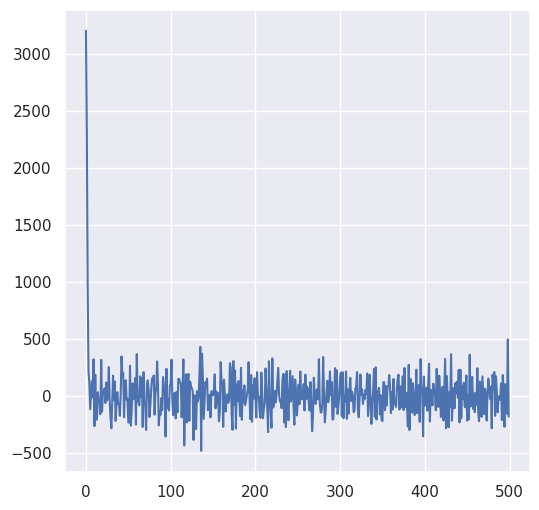

In [ ]:
# PLot the cumulative reward 
import seaborn as sns 
sns.set(rc={'figure.figsize':(6,6)})
sns.lineplot(x = range(500), y = crpe)